# The Myers-Briggs Type Indicator (MBTI)

![image.png](https://www.myersbriggs.org/_images/leftContentImages/img_my-mbti-personality-type.jpg)

The purpose of the [Myers-Briggs Type Indicator® (MBTI®)](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/) personality inventory is to make the theory of psychological types described by C. G. Jung understandable and useful in people's lives. The essence of the theory is that much seemingly random variation in the behavior is actually quite orderly and consistent, being due to basic differences in the ways individuals prefer to use their perception and judgment.

There are [16 personality types](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/the-16-mbti-types.htm) in the Myers-Briggs Type Indicator®.

## About The Dataset:
This dataset contains over 8600 rows of data, on each row is a person’s:
- Type (This persons 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))


## Problem Description
هنا نكتب عن الكلاسيفاير وليش اخترنا وكذا

Use this simple hack for Auto-Click to avoid being kicked off Colab VM
Press (Ctrl + Shift + i) . Go to console. Paste the following code and press Enter.
```
function ClickConnect(){
console.log("Working");
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click()
}
setInterval(ClickConnect,60000)
```


#### Imports

In [126]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#### Preprocessing

###### 1. Read the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [127]:
df = pd.read_csv('drive/MyDrive/mbti_1.csv')
df["posts"] # There are URLs that need to be removed

0       'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       'I'm finding the lack of me in these posts ver...
2       'Good one  _____   https://www.youtube.com/wat...
3       'Dear INTP,   I enjoyed our conversation the o...
4       'You're fired.|||That's another silly misconce...
                              ...                        
8670    'https://www.youtube.com/watch?v=t8edHB_h908||...
8671    'So...if this thread already exists someplace ...
8672    'So many questions when i do these things.  I ...
8673    'I am very conflicted right now when it comes ...
8674    'It has been too long since I have been on per...
Name: posts, Length: 8675, dtype: object

###### 2. Clean the data

In [128]:
def clean(txt):
  posts = txt.split("|||") # split so that each post is seperated
  for i in range(len(posts)):
    posts[i] = re.sub(r"http\S+", "(URL)", posts[i]) # replace the link with the word URL

  return posts

# clean the posts and separate them
# then remove any leftover empty strings
df["posts_cleaned"] = df["posts"].apply(clean).apply(lambda x: list(filter(None, x)))
df["posts_cleaned"]

0       ['(URL), (URL), enfp and intj moments  (URL)  ...
1       ['I'm finding the lack of me in these posts ve...
2       ['Good one  _____   (URL), Of course, to which...
3       ['Dear INTP,   I enjoyed our conversation the ...
4       ['You're fired., That's another silly misconce...
                              ...                        
8670    ['(URL), IxFP just because I always think of c...
8671    ['So...if this thread already exists someplace...
8672    ['So many questions when i do these things.  I...
8673    ['I am very conflicted right now when it comes...
8674    ['It has been too long since I have been on pe...
Name: posts_cleaned, Length: 8675, dtype: object

#### Visualization

###### 1. WordCloud
What are the most used words in each class?

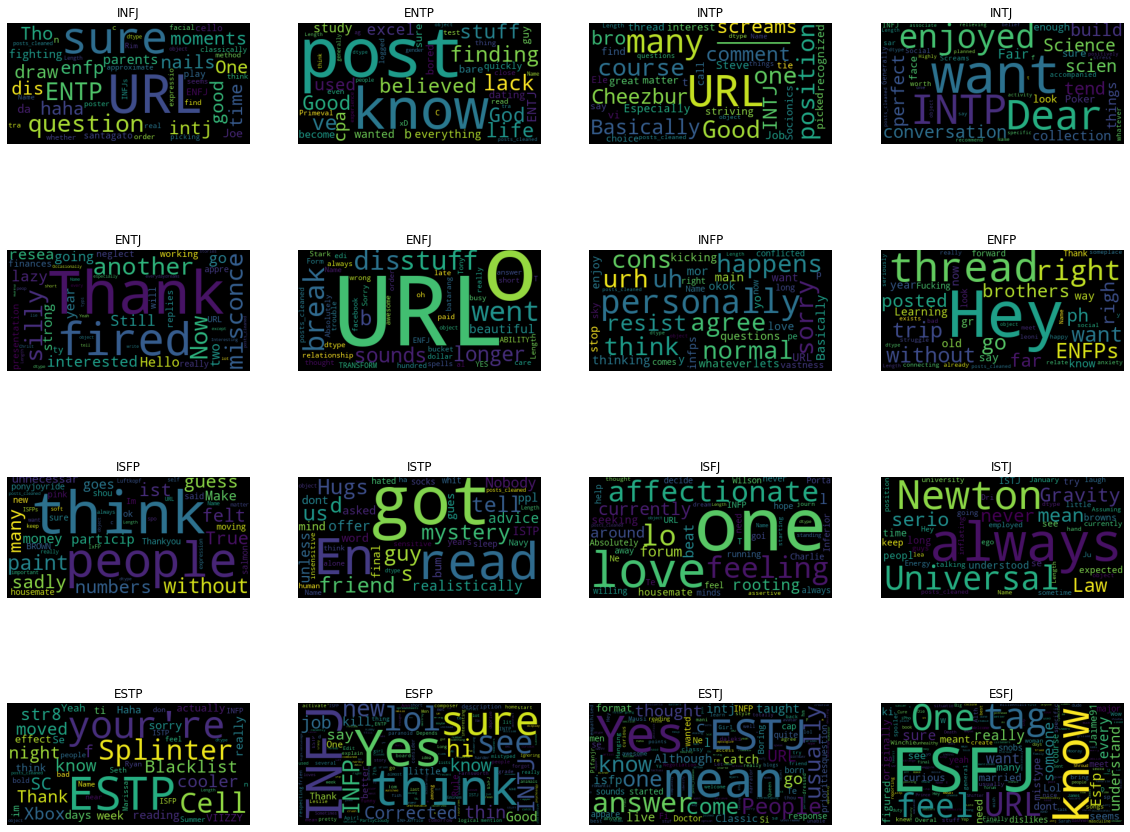

In [129]:
types = df["type"].unique() # 16 types

fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True, figsize=(20, len(types)))

t = 0
for i in range(4):
  for j in range(4):
    wc = WordCloud().generate(str(df[df["type"] == types[t]]["posts_cleaned"]))
    ax[i, j].imshow(wc)
    ax[i, j].set_title(types[t])
    ax[i, j].axis("off")
    t+=1

###### 2. Barplot
The class with the most instances is INFP. Meanwhile, the class with the least instances is ESTJ. 

This dataset is [imbalanced](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)!

***What should we do?***

- First, we should **NOT** use accuracy as an evaluation metric, ***why?***

  Because class imbalance leads to a heavy bias/skew towards larger classes and classes with fewer data points are treated as **noise** and are often **ignored**. The result is a higher misclassification rate for minority classes compared to the majority classes. Therefore, the accuracy metric is not as relevant when evaluating the performance of a model trained on imbalanced data.

- We can use Oversampling — This is the process of replicating the minority class instances randomly. This approach may lead to overfitting.
- We can also use Undersampling — This is the process of eliminating data points from the majority class randomly until the classes are balanced. There is a likelihood of information loss which might lead to poor model training  if the data is not big enough.
- Data augmentation - Mostly used in Computer Vision, in the case of textual data, the is not enough documentation.

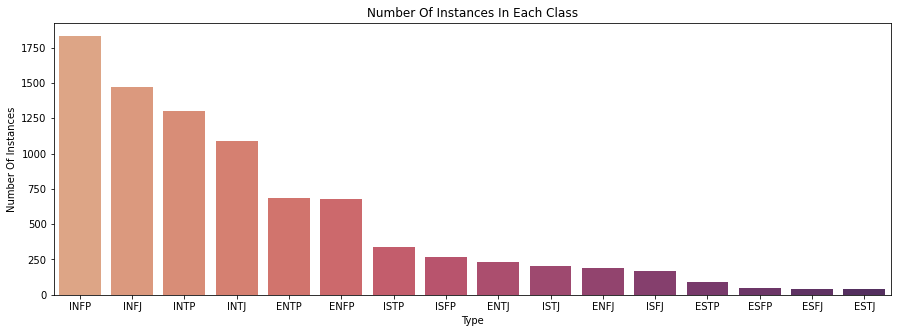

In [130]:
num_in_types = df["type"].value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=num_in_types.index, y=num_in_types.values, 
            palette="flare").set(title="Number Of Instances In Each Class",
                                 xlabel="Type", ylabel="Number Of Instances");

###### 3. Plot 3
We got that the most range number for words per post is approximately about 30 words 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


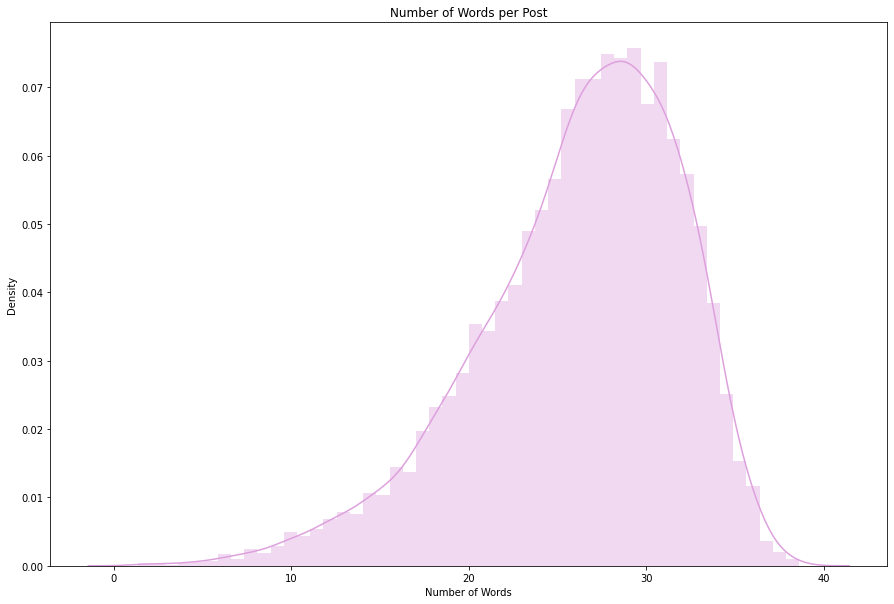

In [152]:
def count_words_per_post(posts):
  count = 0
  for post in posts:
    count += len(post.split())
  
  return count/len(posts)

num_words = df["posts_cleaned"].apply(count_words_per_post)

plt.figure(figsize=(15,10))
sns.distplot(num_words, color="plum").set(title="Number of Words per Post", 
                                       xlabel="Number of Words");

###### 4. Plot 4
write some insights here please @raghad

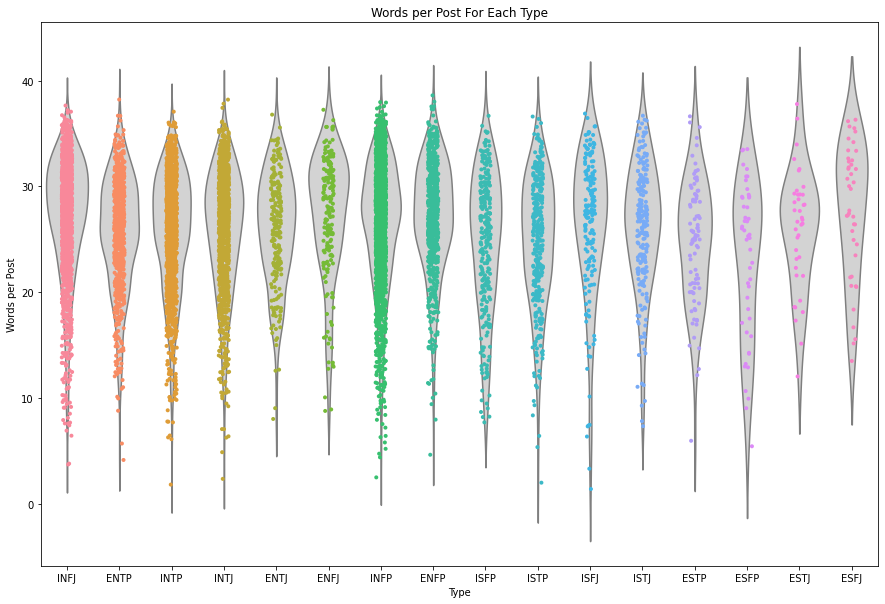

In [156]:
plt.figure(figsize=(15, 10))
sns.violinplot(x="type", y=num_words , data=df, inner=None, color="lightgray")
sns.stripplot(x="type", y= num_words , data=df, size=4, 
              jitter=True).set(title="Words per Post For Each Type", 
                               ylabel="Words per Post", xlabel="Type");

###### 5. Plot 5
write some insights here please @raghad

In [135]:
def var_row(row):
    l = []
    for i in row:
        l.append(len(i.split()))
    return np.var(l)

df["variance_of_word_counts"] = df["posts_cleaned"].apply(lambda x: var_row(x))
df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x1440 with 0 Axes>

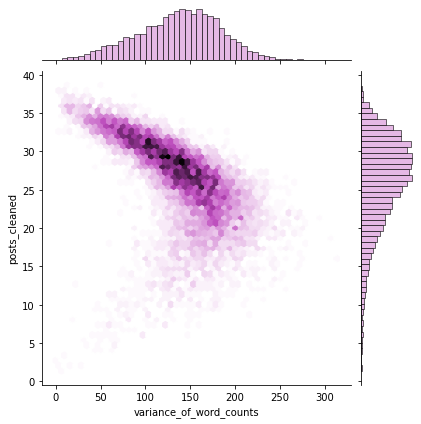

In [151]:
plt.figure(figsize=(15,20))
sns.jointplot("variance_of_word_counts", num_words, data=df, 
              kind="hex", color="plum");

## Training The Models

To solve the class imbalance problem we will be using [Synthetic Minority Oversampling (SMOTE) Technique](https://www.dominodatalab.com/blog/smote-oversampling-technique). We will compare the results with and without oversampling.


Transform a count matrix to a normalized tf or tf-idf representation.

Tf means term-frequency while tf-idf means term-frequency times inverse
document-frequency. This is a common term weighting scheme in information
retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a
token in a given document is to scale down the impact of tokens that occur
very frequently in a given corpus and that are hence empirically less
informative than features that occur in a small fraction of the training
corpus.

The formula that is used to compute the tf-idf for a term t of a document d
in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is
computed as idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False), where
n is the total number of documents in the document set and df(t) is the
document frequency of t; the document frequency is the number of documents
in the document set that contain the term t. The effect of adding "1" to
the idf in the equation above is that terms with zero idf, i.e., terms
that occur in all documents in a training set, will not be entirely
ignored.

هنا نكثر كلام وصور عن السموت وتي اف وكاونت فيكتور

In [157]:
X = np.transpose(np.stack(df['posts_cleaned'].apply(lambda x: " ".join(x))))
y = np.transpose(np.stack(df["type"])) # transform it into 2D array 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0, stratify=y)

#### Scoring:

`neg_log_loss`:

  [Log loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss), aka logistic loss or cross-entropy loss.

  This is the loss function used in (multinomial) logistic regression and extensions of it such as neural networks, defined as the negative log-likelihood of a logistic model that returns *y_pred* (aka `y_hat`) probabilities for its training data *y_true* (aka `y_test`).
 
  `neg_log_loss` is basically -log loss.

In [158]:
grid_score = "neg_log_loss"

#### 1. Multinomial Naïve Bayes

In [159]:
mnb_param=[{"mnb__alpha":[0.01, 0.1, 1, 10, 100]}]

###### Without SMOTE Oversampling

In [160]:
mnb_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("tfidf", TfidfTransformer()),
  ("mnb", MultinomialNB())
])
grid_mnb = GridSearchCV(estimator=mnb_pipeline, param_grid=mnb_param, 
                        scoring=grid_score, cv=3)

In [161]:
grid_mnb.fit(X_train, y_train) # train

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('mnb', MultinomialNB())]),
             param_grid=[{'mnb__alpha': [0.01, 0.1, 1, 10, 100]}],
             scoring='neg_log_loss')

In [162]:
y_hat = grid_mnb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       0.78      0.13      0.23       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.43      0.17      0.24       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.42      0.48      0.45       294
        INFP       0.38      0.87      0.53       366
        INTJ       0.56      0.39      0.46       218
        INTP       0.49      0.60      0.54       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.50      0.02      0.05        41
        ISTP       1.00      0.04      0.09        67

    accuracy                           0.43      1735
   macro avg       0.28   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


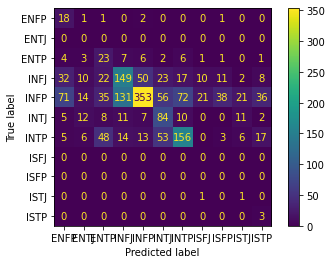

In [163]:
plot_confusion_matrix(grid_mnb.best_estimator_, y_test, y_hat)

In [164]:
print(grid_mnb.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

INFP


###### With SMOTE Oversampling

In [179]:
mnb_smote_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("smote", SMOTE(random_state=12)),
  ("mnb", MultinomialNB())
])

grid_mnb_smote = GridSearchCV(estimator=mnb_pipeline, param_grid=mnb_param, 
                              scoring=grid_score, cv=3)

In [ ]:
grid_mnb_smote.fit(X_train, y_train) # train

In [ ]:
y_hat = grid_mnb_smote.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))

In [ ]:
plot_confusion_matrix(grid_mnb_smote.best_estimator_, y_test, y_hat);

In [ ]:
print(grid_mnb_smote.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

#### 2. Logistic Regression

In [ ]:
# penalty{ ‘l2’, ‘none’}, default=’l2’
# Specify the norm of the penalty:

# 'none': no penalty is added;

# 'l2': add a L2 penalty term and it is the default choice;

# 'l1': add a L1 penalty term;

# solver 
# ‘newton-cg’ - [‘l2’, ‘none’]

# ‘lbfgs’ - [‘l2’, ‘none’]


# C def 1 small(no effect) large(underfitting)

###### Without SMOTE Oversampling

###### With SMOTE Oversampling

#### 3. XGBClassifier
[XGBoost](https://www.geeksforgeeks.org/xgboost/) stands for Extreme Gradient Boosting, which was proposed by the researchers at the University of Washington. It is a library written in C++ which optimizes the training for Gradient Boosting.


In [170]:
xgb_param = [{"xgb__booster": ["gbtree", "gblinear", "dart"],
              "xgb__n_estimators": [4, 6, 8], "xgb__max_depth": [4, 6, 8],
              "xgb__gamma": [0, 0.5, 1], 
              "xgb__learning_rate": [0.001, 0.01, 0.1]}]

###### Without SMOTE Oversampling

In [171]:
xgb_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("tfidf", TfidfTransformer()),
  ("xgb", XGBClassifier(random_state=0))
])
grid_xgb = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param, 
                        scoring=grid_score, cv=3)

In [172]:
grid_xgb.fit(X_train, y_train) # train

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_features=5000,
                                                        stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('xgb', XGBClassifier())]),
             param_grid=[{'xgb__booster': ['gbtree', 'gblinear', 'dart'],
                          'xgb__gamma': [0, 0.5, 1],
                          'xgb__learning_rate': [0.001, 0.01, 0.1],
                          'xgb__max_depth': [4, 6, 8],
                          'xgb__n_estimators': [4, 6, 8]}],
             scoring='neg_log_loss')

In [173]:
y_hat = grid_xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

        ENFJ       0.93      0.34      0.50        38
        ENFP       0.64      0.56      0.60       135
        ENTJ       0.90      0.39      0.55        46
        ENTP       0.67      0.58      0.62       137
        ESFJ       0.50      0.11      0.18         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.67      0.25      0.36         8
        ESTP       0.83      0.28      0.42        18
        INFJ       0.64      0.66      0.65       294
        INFP       0.61      0.83      0.70       366
        INTJ       0.65      0.64      0.65       218
        INTP       0.68      0.73      0.70       261
        ISFJ       0.48      0.36      0.41        33
        ISFP       0.43      0.41      0.42        54
        ISTJ       0.58      0.37      0.45        41
        ISTP       0.78      0.63      0.69        67

    accuracy                           0.64      1735
   macro avg       0.62   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


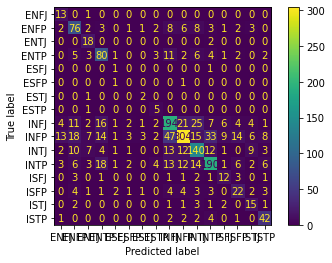

In [174]:
plot_confusion_matrix(grid_xgb.best_estimator_, y_test, y_hat);

In [178]:
print(grid_xgb.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test

INFP


###### With SMOTE Oversampling

In [176]:
xgb_smote_pipeline = Pipeline([
  ("vect", CountVectorizer(ngram_range=(1, 1), lowercase=True, 
                           max_features = 5000, stop_words="english")),
  ("tfidf", TfidfTransformer()),
  ("smote", SMOTE(random_state=12)),
  ("xgb", XGBClassifier(random_state=0))
])
grid_xgb_smote = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_param, 
                        scoring=grid_score, cv=3)

In [177]:
grid_xgb_smote.fit(X_train, y_train) # train

KeyboardInterrupt: ignored

In [ ]:
y_hat = grid_xgb_smote.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, zero_division=0))

In [ ]:
plot_confusion_matrix(grid_xgb_smote.best_estimator_, y_test, y_hat);

In [ ]:
print(grid_xgb_smote.best_estimator_.predict(
    ["Good Morning Everyone , Happy Nice Day :D"])[0]) # sample test